In [250]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [251]:
from Copter.Session import Session
from Copter.Network import Network
net = Network(3, 4)
s = Session(net, step_size=1e-3, jerk_loss_coeff=0.0)

In [254]:
s.train_model(100, 1000)

d:\STUDY\code\ML notebooks\my\copter\Copter\Session.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.iteration += 1
d:\STUDY\code\ML notebooks\my\copter\Copter\Session.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if self.success is None:


-3132.9804243445396 130
-3073.228813111782 132
-2470.5432574748993 121
-5013.953898489475 149
-4364.161668300629 145
-2520.3074471354485 120
-2978.5688748955727 128
-4003.904238164425 140
-3072.298923909664 134
-1883.606130182743 110
-2182.9279487133026 121
-1420.8522322773933 100
-3367.7455741763115 129
-2013.4484146237373 117
-1617.32145267725 108
-9128.30445688963 168
-1576.3733502030373 102
-1625.6615883708 101
-1817.3233384490013 107
-1881.7525212168694 109
-333262.58635801077 271
-1787.4047259688377 108
-4628.150467693806 164
-1523.3963492512703 106
-2492.336054980755 125
-2224.231379568577 116
-1129.8515529036522 104
-2968.0849803090096 132
-1621.7677738070488 103
-2746.277296066284 134
-1768.3083340525627 115
-1724.7507738471031 105
-1714.1085759997368 106
-1723.9360577464104 108
-2486.8613464832306 130
-1914.82216912508 120
-1755.232629597187 111
-1429.9956998229027 105
-1101.8415421843529 104
-1865.5166835188866 116
-1767.8973651528358 114
-2037.7818431258202 124
-45873.10227

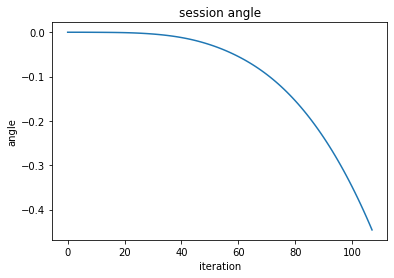

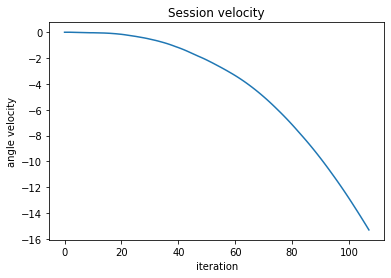

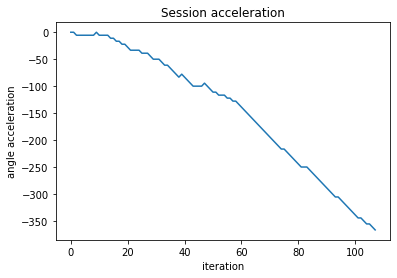

In [255]:
s.plot_states()

In [234]:
s.plot_actions()

AttributeError: 'Session' object has no attribute 'plot_actions'

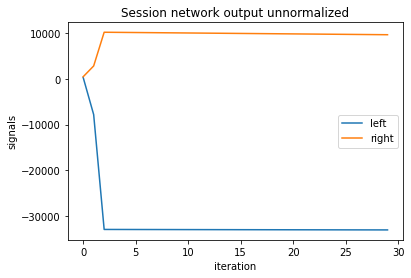

In [145]:
s.plot_signals()

In [14]:
from utils import compute_total_J
compute_total_J(False)

21.8


12956637.786666665

In [63]:
from Copter.Session import Session
s = Session()
s.run(10)

d:\STUDY\code\ML notebooks\my\copter\Copter\TwoMotorStick.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probas = F.softmax(logits).numpy()


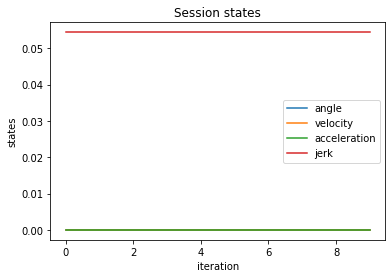

In [64]:
s.plot_states()

In [1]:
# all parameters in mm's and gramms

# STICK_LENGTH = 370.
# STICK_HEIGHT = 59.
# STICK_MASS = 196.

# MOTOR_MASS = 67.
# MOTOR_DISTANCE = 158.
# MOTOR_HEIGHT = 50.

# REGULATOR_MASS = 24.
# REGULATOR_DISTANCE = 70.
# REGULATOR_HEIGHT = 32.

# CENTER_AXIS_IDENT = 17.5
# PILLAR_HEIGH = 0
from model_parameters import *
2 * (MOTOR_MASS * MOTOR_HEIGHT + REGULATOR_MASS * REGULATOR_HEIGHT) \
    / (2 * MOTOR_MASS + 2 * REGULATOR_MASS + STICK_MASS)

21.788359788359788

In [1]:
import torch

In [10]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6])
c = torch.vstack([a, b])
torch.square(c)

tensor([[ 1,  4,  9],
        [16, 25, 36]])

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch


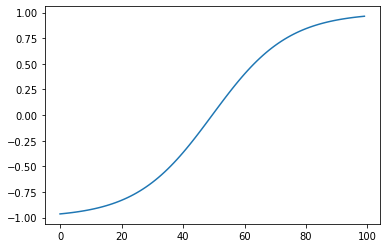

In [22]:
space = np.linspace(-2, 2, 100)
ans = []
for a in space:
    ans.append(torch.tanh(torch.tensor(a)).item())
plt.plot(ans)

In [44]:
import math
mean = 1
var = 1

In [45]:
np.random.normal(mean, var)

1.3196001152839887

In [46]:
a = np.array([1, 3])
a.tolist()

[1, 3]

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [167]:
df = pd.read_csv('Motor force detection.csv')

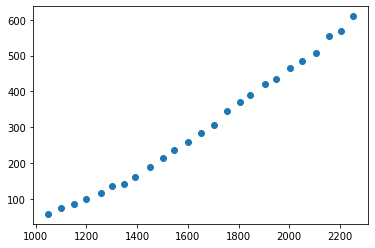

In [168]:
plt.scatter(x=df.input, y=df.mass)

In [169]:
lr = LinearRegression()
lr.fit(df.drop('mass', axis=1), df.mass)

LinearRegression()

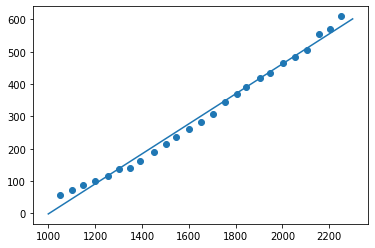

In [170]:
space = np.linspace(1000, 2300)
preds = lr.intercept_ + lr.coef_[0] * space
plt.plot(space, preds)
plt.scatter(x=df.input, y=df.mass)
plt.show()

In [171]:
np.array([lr.intercept_, lr.coef_[0]]) * 1e-3 * 9.8

array([-4.56204418e+00,  4.54791687e-03])

In [172]:
lr.predict(np.array([[2300]]))

array([601.85353414])

In [173]:
np.random.choice(2, 1, p=np.array([0.3, 0.7]))[0]

[autoreload of Copter.TwoMotorStick failed: Traceback (most recent call last):
  File "C:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "d:\STUDY\code\ML notebooks\my\copter\Copter\TwoMotorStick.py", line 4, in 

1

In [192]:
a = torch.rand(4,4)
a

tensor([[0.1376, 0.8149, 0.3219, 0.1905],
        [0.3193, 0.3232, 0.3588, 0.0897],
        [0.7505, 0.8373, 0.6066, 0.6727],
        [0.3603, 0.9797, 0.6747, 0.3969]])

In [193]:
a[:, :2]

tensor([[0.1376, 0.8149],
        [0.3193, 0.3232],
        [0.7505, 0.8373],
        [0.3603, 0.9797]])